## Imports

In [55]:
%tensorflow_version 2.x
! pip install git+git://github.com/anfederico/Gemini.git
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from helper import windowed_dataset

  Cloning git://github.com/anfederico/Gemini.git to /tmp/pip-req-build-1u9dzejr
  Running command git clone -q git://github.com/anfederico/Gemini.git /tmp/pip-req-build-1u9dzejr
  Created wheel for gemini: filename=gemini-1.0.0-cp36-none-any.whl size=37371 sha256=f70a68dba67d73e9f553670fecb848550e55dea107baac70a533faaecef2daee
  Stored in directory: /tmp/pip-ephem-wheel-cache-65273z7i/wheels/96/c4/35/d73bfb8dc4304cc3bea43263d5efcf2f1b3985876acdcc3191
Successfully built gemini


## Load and prepare data

In [0]:
fname = '/content/BTCUSD_12h_2011-09-13_to_2019-10-23_bitstamp.csv'
data = pd.read_csv(fname)
data.set_index('date', inplace=True)
#check the data
data.head()

,open,high,low,close,volume
date,,,,,
2011-09-13 12:00:00,5.80,6.00,5.65,5.97,58.371382
2011-09-14 00:00:00,5.58,5.72,5.52,5.52,59.108684
2011-09-14 12:00:00,5.52,5.53,5.52,5.53,2.037300
2011-09-15 00:00:00,5.12,5.12,5.00,5.00,50.546583
2011-09-15 12:00:00,5.21,5.24,5.13,5.13,29.594212


In [0]:
# linear interpolation to fill missing values
data = data.interpolate()

# add returns, i.e. percentage change
data['returns'] = data['high'].pct_change(periods=1)

# check the data
data.head()

,open,high,low,close,volume,returns
date,,,,,,
2011-09-13 12:00:00,5.80,6.00,5.65,5.97,58.371382,NaN
2011-09-14 00:00:00,5.58,5.72,5.52,5.52,59.108684,-0.046667
2011-09-14 12:00:00,5.52,5.53,5.52,5.53,2.037300,-0.033217
2011-09-15 00:00:00,5.12,5.12,5.00,5.00,50.546583,-0.074141
2011-09-15 12:00:00,5.21,5.24,5.13,5.13,29.594212,0.023438


### Split data into training and validation sets

In [0]:
N = data.shape[0]
split_t = int(N * .70)                               # 70% Validation

time_train = data.index[1:split_t]                   # skip to first value since it is NaN
x_train = data['returns'][1:split_t].to_numpy()      # first  70%
y_train = 100 * data['returns'][2:split_t + 1].to_numpy()  # first 70%
time_valid = data.index[split_t:]
x_valid = data['returns'][split_t:-1].to_numpy()     # last 30%
y_valid = 100 * data['returns'][split_t + 1:].to_numpy()   # last 30%

(-25, 25)

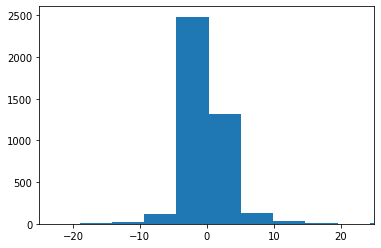

In [0]:
plt.hist(y_train, 100)
plt.xlim([-25, 25])

## Build a model

In [0]:
tf.keras.backend.clear_session()
win_sz = 50
batch_sz = 60

train_data = windowed_dataset(x_train, y_train, win_sz, batch_sz, kind='regress')
valid_data = windowed_dataset(x_valid, y_valid, win_sz, batch_sz, kind='regress')

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, activation='relu', return_sequences= False)),
    tf.keras.layers.Dense(1)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mse'])

## Learning rate optimization

In [0]:
history = model.fit(train_data, epochs=20, callbacks=[lr_schedule])
np.save('lr_history.npy', history.history)

Train for 69 steps
Epoch 1/20
69/69 [==============================] - 11s 160ms/step - loss: 1.3725 - mse: 51.0917
Epoch 2/20
69/69 [==============================] - 9s 131ms/step - loss: 1.4975 - mse: 89.0999
Epoch 3/20
69/69 [==============================] - 9s 129ms/step - loss: 1.3792 - mse: 48.3066
Epoch 4/20
69/69 [==============================] - 9s 131ms/step - loss: 1.5105 - mse: 87.0024
Epoch 5/20
69/69 [==============================] - 9s 134ms/step - loss: 1.4327 - mse: 51.0952
Epoch 6/20
69/69 [==============================] - 9s 131ms/step - loss: 1.3278 - mse: 47.8507
Epoch 7/20
69/69 [==============================] - 9s 131ms/step - loss: 1.4728 - mse: 52.8358
Epoch 8/20
69/69 [==============================] - 9s 130ms/step - loss: 1.5075 - mse: 89.6240
Epoch 9/20
69/69 [==============================] - 9s 132ms/step - loss: 1.3906 - mse: 51.3883
Epoch 10/20
69/69 [==============================] - 9s 131ms/step - loss: 1.4811 - mse: 51.6919
Epoch 11/20
69/69 [

### Plot the loss as a function of learning rate

best learning rate: 3.548134e-08


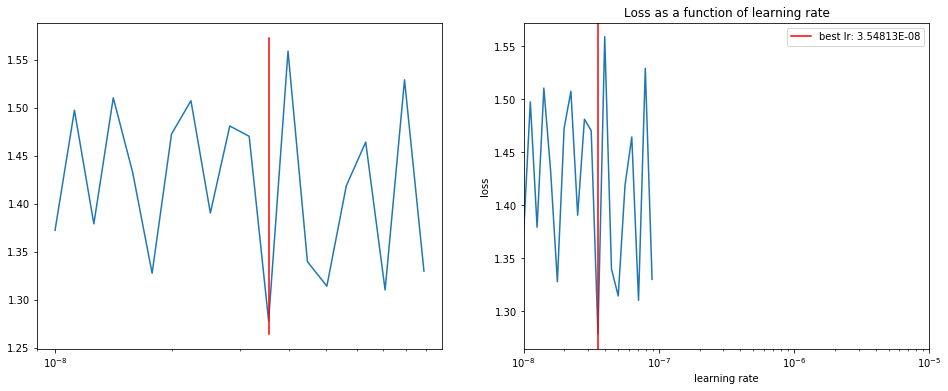

In [0]:
history = np.load('lr_history.npy', allow_pickle=True).item()
learning_rates = history['lr']
loss = history['loss']

fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(121)
ax.semilogx(learning_rates, loss)
# get index of lowest loss
minloss_i = np.argmin(loss)
# get the learning rate at that index
min_lr = learning_rates[minloss_i]
# plot best learing rate, and add value to label
ax.plot([min_lr, min_lr], ax.get_ylim(), 'r', label='best lr: {:.5E}'.format(min_lr))


ax = fig.add_subplot(122)
ax.semilogx(learning_rates, loss)
# ax.set_ylim([0, 1e-4])
ax.set_xlim([learning_rates[0], 1e-5])
ylim = ax.get_ylim()
ax.set_ylim([ylim[0]*1.000025, ylim[-1]*.99933])
# get index of lowest loss
minloss_i = np.argmin(loss)
# get the learning rate at that index
best_lr = learning_rates[minloss_i]
# plot best learing rate, and add value to label
ax.plot([best_lr, best_lr], ax.get_ylim(), 'r', label='best lr: {:.5E}'.format(best_lr))
# Print the best learning rate
print('best learning rate:', best_lr)
ax.set_xlabel('learning rate')
ax.set_ylabel('loss')
ax.set_title('Loss as a function of learning rate')
ax.legend()
fig.savefig('loss_lr.png')

## Train with the best learning rate

In [0]:
tf.keras.backend.clear_session()
# best_lr = 7.079458e-07 (Hjalmar's 2layer NN);
epochs = 100

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, activation='relu', return_sequences= False)),
  tf.keras.layers.Dense(1)])

     

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
loss = tf.keras.losses.MeanSquaredError()
model.compile(loss=loss, optimizer='adam', metrics=["mse"])
history = model.fit(train_data, epochs=epochs, validation_data=valid_data)

# save the trained model
model.save('BidirLSTM_96Gold_epochs%d.h5' % epochs)
# save the history
np.save('BidirLSTM_96Gold_epochs%d.npy' % epochs, history.history)

Train for 69 steps, validate for 29 steps
Epoch 1/100
69/69 [==============================] - 13s 184ms/step - loss: 11.4798 - mse: 11.4798 - val_loss: 6.9206 - val_mse: 6.9206
Epoch 2/100
69/69 [==============================] - 10s 144ms/step - loss: 49.1107 - mse: 49.1107 - val_loss: 7.1857 - val_mse: 7.1857
Epoch 3/100
69/69 [==============================] - 10s 142ms/step - loss: 50.1431 - mse: 50.1431 - val_loss: 7.0524 - val_mse: 7.0524
Epoch 4/100
69/69 [==============================] - 10s 143ms/step - loss: 51.1308 - mse: 51.1308 - val_loss: 7.7833 - val_mse: 7.7833
Epoch 5/100
69/69 [==============================] - 10s 142ms/step - loss: 11.3072 - mse: 11.3072 - val_loss: 7.0559 - val_mse: 7.0559
Epoch 6/100
69/69 [==============================] - 10s 145ms/step - loss: 272.0002 - mse: 272.0002 - val_loss: 7.8619 - val_mse: 7.8619
Epoch 7/100
69/69 [==============================] - 10s 147ms/step - loss: 86.2940 - mse: 86.2940 - val_loss: 8.0659 - val_mse: 8.0659
Epoc

In [0]:
# Load a saved model
model = tf.keras.models.load_model('BidirLSTM_96Gold_epochs%d.h5' % epochs)

## Evaluate forecast performance

### Relationship between forecast and x_valid
<img src="forecast_illustration.png" style="width:850px;"/>

In code:

```python
    x_valid[1:]
    forecast[:-1]
```

### Evaluation

* Comparing with a naive/mean forecast
* Plot for visual inspection
* Accuracy of direction (i.e. the sign of forecast correct)

LSTM validation MSE: 0.019669, mean forecast: 0.000757


Text(0, 0.5, 'Percent change')

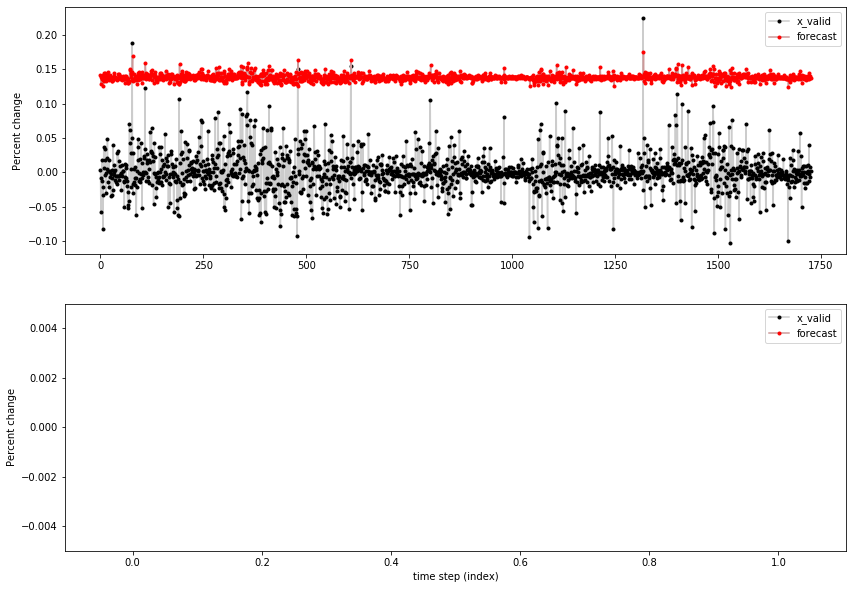

In [0]:
forecast = model.predict(x_valid)
mean_forecast = np.ones(x_valid[win_sz:].shape) * x_valid.mean()
rnn_mse = mean_squared_error(x_valid[win_sz+1:], forecast[win_sz:-1].flatten())
meanforecast_mse = mean_squared_error(x_valid[win_sz:], mean_forecast)
print('LSTM validation MSE: %.6f, mean forecast: %.6f' % (rnn_mse, meanforecast_mse))


fig = plt.figure(figsize=[14,10])
ax = fig.add_subplot(211)
ax.plot(x_valid[win_sz+1:], '.-', color=[.8]*3, mfc='k', mec='k', label='x_valid')
ax.plot(forecast[win_sz:-1].flatten(), '.-', color=[.8, .6, .6], mfc='r', mec='r', label='forecast')
ax.legend()
ax.set_ylabel('Percent change')

ax = fig.add_subplot(212)
ax.plot(x_valid[win_sz+40001:], '.-', color=[.8]*3, mfc='k', mec='k', label='x_valid')
ax.plot(forecast[win_sz+40000:-1].flatten(), '.-', color=[.8, .6, .6], mfc='r', mec='r', label='forecast')
ax.set_ylim([-.005, 0.005])
ax.legend()
ax.set_xlabel('time step (index)')
ax.set_ylabel('Percent change')

In [0]:
y_true = x_valid[win_sz+1:] > 0
y_hat = forecast[win_sz:-1].flatten() > 0
acc = 100 * (y_true == y_hat).sum() / len(y_true)
chance = max(y_true.mean(), 1 - y_true.mean()) * 100             
print('Forecasting direction of change\n\tAccuracy: %1.3f%% (chance: %1.3f%%)' % (acc, chance))

Forecasting direction of change
	Accuracy: 46.987% (chance: 53.013%)


## Check how many epochs are required to minimize the loss

In [0]:
# load history saved from training
history = np.load('BidirLSTM_96Gold_epochs%d.npy' % epochs, allow_pickle=True).item()

In [0]:
history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

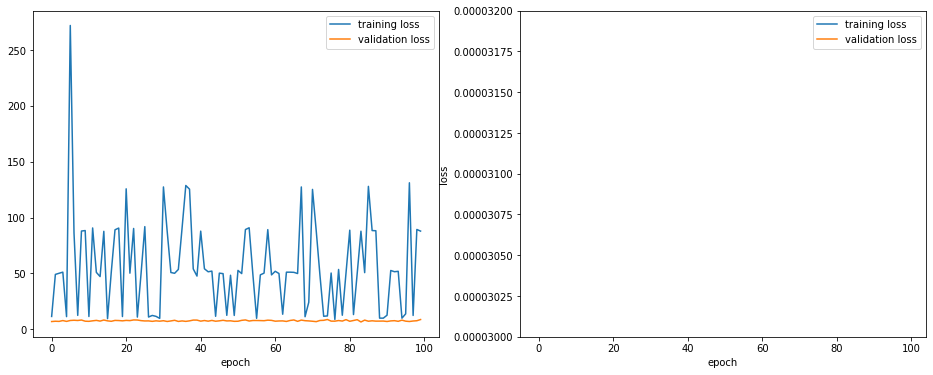

In [0]:
fig = plt.figure(figsize=[16, 6])
ax = fig.add_subplot(121)
ax.plot(history['loss'], label='training loss')
ax.plot(history['val_loss'], label='validation loss')
ax.set_xlabel('epoch')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(history['loss'], label='training loss')
ax.plot(history['val_loss'], label='validation loss')
# ax.set_ylim([7.2193185e-06, 7.219321e-06])
ax.set_ylim([0.00003, 0.000032])
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()

## Testing data

The training and validation data have been from Bitstamp and the last sample is from 2019-10-23.
For testing we can get the latest data from Binance, the exchange where we will trade.

### Helper function to download data from Binance
See ```helper.py``` for that and more helper functions.

For backtesting with Gemini, the data needs to be in a Pandas DataFrame with, at least, the following columns:
```'high', 'low', 'open', 'close', 'volume'```

In [0]:
from datetime import datetime
from datetime import timezone
import helper

In [0]:
klines = helper.get_klines(start_t=[2018, 9, 1, 0, 0, 0], interval='12h')

2019-11-19 23:59


In [0]:
klines.head()

,open_ts,open,high,low,close,volume,close_ts,returns
date,,,,,,,,
2018-09-01 11:59:59.999000+00:00,1.535760e+12,7011.21,7113.62,7008.74,7069.01,15171.335257,1.535803e+12,NaN
2018-09-01 23:59:59.999000+00:00,1.535803e+12,7069.34,7275.00,7031.00,7200.01,25152.078836,1.535846e+12,0.022686
2018-09-02 11:59:59.999000+00:00,1.535846e+12,7201.57,7345.45,7127.00,7232.00,21834.367836,1.535890e+12,0.009684
2018-09-02 23:59:59.999000+00:00,1.535890e+12,7230.75,7333.33,7174.47,7302.01,17980.472516,1.535933e+12,-0.001650
2018-09-03 11:59:59.999000+00:00,1.535933e+12,7302.00,7325.00,7191.63,7226.60,15346.308031,1.535976e+12,-0.001136


In [0]:
klines.tail()

,open_ts,open,high,low,close,volume,close_ts,returns
date,,,,,,,,
2019-11-16 23:59:59.999000+00:00,1.573906e+12,8478.79,8526.24,8453.60,8491.02,8536.265581,1.573949e+12,-0.001962
2019-11-17 11:59:59.999000+00:00,1.573949e+12,8490.74,8591.83,8350.68,8521.26,14474.212667,1.573992e+12,0.007693
2019-11-17 23:59:59.999000+00:00,1.573992e+12,8521.26,8635.00,8455.55,8502.40,12534.824415,1.574035e+12,0.005025
2019-11-18 11:59:59.999000+00:00,1.574035e+12,8502.87,8503.52,8415.00,8443.77,12166.119431,1.574078e+12,-0.015226
2019-11-18 23:59:59.999000+00:00,1.574078e+12,8443.90,8465.48,8060.00,8211.00,22322.636559,1.574122e+12,-0.004473


In [0]:
klines.to_csv('BTCUSD_12h_2018-09-01_to_2019-11-18_binance.csv')

## Time for backtesting

Check the Gemini [documentation](https://gemini-docs.readthedocs.io/en/latest/) and [old examples](https://github.com/anfederico/Gemini/blob/master/docs/using-gemini.rst)

### imports

In [0]:
from gemini import engine
from helper import load_binance_klines
import os
import numpy as np
import tensorflow as tf
import helper as h

### Helper function for preprocessing

In [0]:
def preprocess(model, data, win_sz=50):
    """
    """
    forecast = model.predict(data['returns'].to_numpy())
    # data['forecast'] = np.nan
    data['forecast'] = forecast.flatten().copy()

    data = data[win_sz:]
    return data

### Trading logic, or strategy

In [0]:
#look at trading-example file and look for logic code

def logic(account, lookback):
    try:

        current_t = lookback.iloc[-1]

        if current_t['forecast'] > 0:  # forcasted price increase

            entry_price = current_t['close']
            risk = 0.8  # Not all in
            entry_capital = account.buying_power * risk
            if entry_capital > 0:
                account.enter_position('long', entry_capital, entry_price)

        elif current_t['forecast'] < 0:  # forcasted price decrease
            exit_price = current_t['close']
            for position in account.positions:
                if position.type == 'long':
                    account.close_position(position, 0.8, exit_price)

    except ValueError:
        pass  # Handles lookback errors in beginning of dataset

### Pre-process and run backtest

In [0]:
# load pre-trained model
model = tf.keras.models.load_model('BidirLSTM_96Gold_epochs%d.h5' % epochs)
fname = os.path.join('BTCUSD_12h_2018-09-01_to_2019-11-18_binance.csv')
# load data
data = load_binance_klines(fname)
# pre-process
data = preprocess(model, data)
# # initialize backtest
backtest = engine.backtest(data)
# Start backtesting custom logic with 10 (BTC) intital capital
backtest.start(10, logic)
# # check results
backtest.results()

-------------- Results ----------------

Buy and Hold : 26.08%
Net Profit   : 2.61
Strategy     : 22.89%
Net Profit   : 2.29
Longs        : 465
Sells        : 0
Shorts       : 0
Covers       : 0
--------------------
Total Trades : 465

---------------------------------------


Group#4 "Become a Millionaire" Strategy Code
